In [5]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import time
import os
from datetime import timedelta
from six.moves import range

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.4.1


In [6]:
# Open the HDF5 file containing the datasets
h5f = h5py.File('data/SVHN_multi.h5','r')

# Extract the datasets
X_train = h5f['train_dataset'][:]
y_train = h5f['train_labels'][:]
X_val = h5f['valid_dataset'][:]
y_val = h5f['valid_labels'][:]
X_test = h5f['test_dataset'][:]
y_test = h5f['test_labels'][:]

# Close the file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (230754, 64, 64, 3) (230754, 5)
Validation set (5000, 64, 64, 3) (5000, 5)
Test set (13068, 64, 64, 3) (13068, 5)


In [7]:
# Get the data dimensions
_, img_height, img_width, num_channels = X_train.shape

# ... and label information
num_digits, num_labels = y_train.shape[1], len(np.unique(y_train))

print(num_digits, num_labels)

5 11


In [8]:
X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

print('Training set', X_train.shape, y_train.shape)

Training set (235754, 64, 64, 3) (235754, 5)


In [9]:

from sklearn.utils import shuffle

# Randomly shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

In [10]:
def subtract_mean(a):
    """ Helper function for subtracting the mean of every image
    """
    for i in range(a.shape[0]):
        a[i] -= int(a[i].mean())
    return a


# Subtract the mean from every image
X_train = subtract_mean(X_train)
X_test = subtract_mean(X_test)


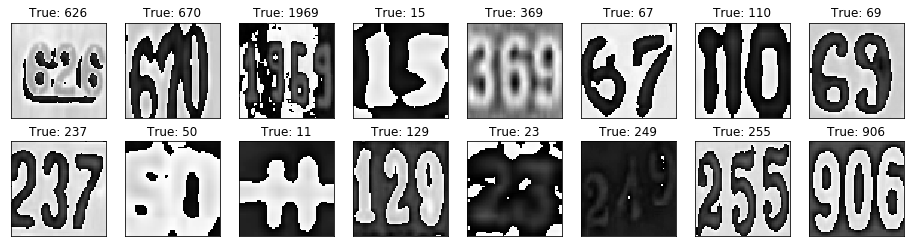

In [11]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    
    # Initialize figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Pretty string with actual number
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # Pretty string with predicted number
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number) 
            
        ax.imshow(images[i,:,:,0], cmap='binary')
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
        
        
# Plot some images from the training set
plot_images(X_train, 2, 8, y_train)

In [12]:
def init_conv_weights(shape, name):
    return tf.get_variable(name, shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def init_fc_weights(shape, name):
    return tf.get_variable(name, shape, initializer=tf.contrib.layers.xavier_initializer())

def init_biases(shape):
    return tf.Variable(tf.constant(0.0, shape=shape))

def conv_layer(input_tensor,    # The input or previous layer
                filter_size,    # Width and height of each filter
                in_channels,    # Number of channels in previous layer
                num_filters,    # Number of filters
                layer_name,     # Layer name
                pooling):       # Use 2x2 max-pooling?
    
    # Add layer name scopes for better graph visualization
    with tf.name_scope(layer_name):
    
        # Shape of the filter-weights for the convolution
        shape = [filter_size, filter_size, in_channels, num_filters]

        # Create weights and biases
        weights = init_conv_weights(shape, layer_name + '/weights')
        biases = init_biases([num_filters])
        
        # Add histogram summaries for weights
        tf.summary.histogram(layer_name + '/weights', weights)
        
        # Create the TensorFlow operation for convolution, with S=1 and zero padding
        activations = tf.nn.conv2d(input_tensor, weights, [1, 1, 1, 1], 'SAME') + biases

        # Rectified Linear Unit (ReLU)
        activations = tf.nn.relu(activations)

        # Do we insert a pooling layer?
        if pooling:
            # Create a pooling layer with F=2, S=1 and zero padding
            activations = tf.nn.max_pool(activations, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')

        # Return the resulting layer
        return activations

In [14]:
def flatten_tensor(input_tensor):
    """ Helper function for transforming a 4D tensor to 2D
    """
    # Get the shape of the input_tensor.
    input_tensor_shape = input_tensor.get_shape()

    # Calculate the volume of the input tensor
    num_activations = input_tensor_shape[1:4].num_elements()
    
    # Reshape the input_tensor to 2D: (?, num_activations)
    input_tensor_flat = tf.reshape(input_tensor, [-1, num_activations])

    # Return the flattened input_tensor and the number of activations
    return input_tensor_flat, num_activations
def fc_layer(input_tensor,  # The previous layer,         
             input_dim,     # Num. inputs from prev. layer
             output_dim,    # Num. outputs
             layer_name,    # The layer name
             relu=False):         # Use ReLU?

    # Add layer name scopes for better graph visualization
    with tf.name_scope(layer_name):
    
        # Create new weights and biases.
        weights = init_fc_weights([input_dim, output_dim], layer_name + '/weights')
        biases = init_biases([output_dim])
        
        # Add histogram summaries for weights
        tf.summary.histogram(layer_name + '/weights', weights)

        # Calculate the layer activation
        activations = tf.matmul(input_tensor, weights) + biases

        # Use ReLU?
        if relu:
            activations = tf.nn.relu(activations)

        return activations

In [15]:
tf.reset_default_graph() 
# Block 1
filter_size1 = filter_size2 = 5          
num_filters1 = num_filters2 = 32        

# Block 2
filter_size3 = filter_size4 = 5          
num_filters3 = num_filters4 = 64

# Block 3
filter_size5 = filter_size6 = filter_size7 = 5          
num_filters5 = num_filters6 = num_filters7 = 128  

# Fully-connected layers
fc1_size = fc2_size = 256

with tf.name_scope("input"):
    
    # Placeholders for feeding input images
    x = tf.placeholder(tf.float32, shape=(None, img_height, img_width, num_channels), name='x')
    y_ = tf.placeholder(tf.int64, shape=[None, num_digits], name='y_')

with tf.name_scope("dropout"):
    
    # Dropout rate applied to the input layer
    p_keep_1 = tf.placeholder(tf.float32)
    tf.summary.scalar('input_keep_probability', p_keep_1)

    # Dropout rate applied after the pooling layers
    p_keep_2 = tf.placeholder(tf.float32)
    tf.summary.scalar('conv_keep_probability', p_keep_2)

    # Dropout rate using between the fully-connected layers
    p_keep_3 = tf.placeholder(tf.float32)
    tf.summary.scalar('fc_keep_probability', p_keep_3)

In [16]:
# Apply dropout to the input layer
drop_input = tf.nn.dropout(x, p_keep_1) 

# Block 1
conv_1 = conv_layer(drop_input, filter_size1, num_channels, num_filters1, "conv_1", pooling=False)
conv_2 = conv_layer(conv_1, filter_size2, num_filters1, num_filters2, "conv_2", pooling=True)
drop_block1 = tf.nn.dropout(conv_2, p_keep_2) # Dropout

# Block 2
conv_3 = conv_layer(conv_2, filter_size3, num_filters2, num_filters3, "conv_3", pooling=False)
conv_4 = conv_layer(conv_3, filter_size4, num_filters3, num_filters4, "conv_4", pooling=True)
drop_block2 = tf.nn.dropout(conv_4, p_keep_2) # Dropout

# Block 3
conv_5 = conv_layer(drop_block2, filter_size5, num_filters4, num_filters5, "conv_5", pooling=False)
conv_6 = conv_layer(conv_5, filter_size6, num_filters5, num_filters6, "conv_6", pooling=False)
conv_7 = conv_layer(conv_6, filter_size7, num_filters6, num_filters7, "conv_7", pooling=True)
flat_tensor, num_activations = flatten_tensor(tf.nn.dropout(conv_7, p_keep_3)) # Dropout

# Fully-connected 1
fc_1 = fc_layer(flat_tensor, num_activations, fc1_size, 'fc_1', relu=True)
drop_fc2 = tf.nn.dropout(fc_1, p_keep_3) # Dropout

# Fully-connected 2
fc_2 = fc_layer(drop_fc2, fc1_size, fc2_size, 'fc_2', relu=True)

# Paralell softmax layers
logits_1 = fc_layer(fc_2, fc2_size, num_labels, 'softmax1')
logits_2 = fc_layer(fc_2, fc2_size, num_labels, 'softmax2')
logits_3 = fc_layer(fc_2, fc2_size, num_labels, 'softmax3')
logits_4 = fc_layer(fc_2, fc2_size, num_labels, 'softmax4')
logits_5 = fc_layer(fc_2, fc2_size, num_labels, 'softmax5')

y_pred = tf.stack([logits_1, logits_2, logits_3, logits_4, logits_5])

# The class-number is the index of the largest element
y_pred_cls = tf.transpose(tf.argmax(y_pred, dimension=2))

with tf.name_scope('loss'):
    
    # Calculate the loss for each individual digit in the sequence
    loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_1, labels=y_[:, 0]))
    loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_2, labels=y_[:, 1]))
    loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_3, labels=y_[:, 2]))
    loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_4, labels=y_[:, 3]))
    loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_5, labels=y_[:, 4]))

    # Calculate the total loss for all predictions
    loss = loss1 + loss2 + loss3 + loss4 + loss5
    tf.summary.scalar('loss', loss)

Instructions for updating:
Use the `axis` argument instead


In [17]:
with tf.name_scope('optimizer'):
    
    # Global step is required to compute the decayed learning rate
    global_step = tf.Variable(0, trainable=False)

    # Apply exponential decay to the learning rate
    learning_rate = tf.train.exponential_decay(1e-3, global_step, 7500, 0.5, staircase=True)
    tf.summary.scalar('learning_rate', learning_rate)

    # Construct a new Adam optimizer
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)

with tf.name_scope("accuracy"):
    
    # Predicted class equals the true class of each image?
    correct_prediction = tf.reduce_min(tf.cast(tf.equal(y_pred_cls, y_), tf.float32), 1)

    # Cast predictions to float and calculate the mean
    accuracy = tf.reduce_mean(correct_prediction) * 100.0
    
    # Add scalar summary for accuracy tensor
    tf.summary.scalar('accuracy', accuracy)

In [18]:
# Launch the graph in a session
session = tf.Session()

saver = tf.train.Saver()

save_path = os.path.join('checkpoints/', 'svhn_multi_v5')

# Use TensorFlow to find the latest checkpoint - if any
try:
    print("Restoring last checkpoint ...")
    
    # Finds the filename of latest saved checkpoint file
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_path)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
    
# If the above failed - initialize all the variables
except:
    print("Failed to restore checkpoint - initializing variables")
    session.run(tf.global_variables_initializer())

    
LOG_DIR = 'logs/svhn_multi_v5/'

# Merge all the summaries and write them out to /logs/svhn_multi
merged = tf.summary.merge_all()

# Pass the graph to the writer to display it in TensorBoard
train_writer = tf.summary.FileWriter(LOG_DIR + '/train', session.graph)
validation_writer = tf.summary.FileWriter(LOG_DIR + '/validation')

Restoring last checkpoint ...
Failed to restore checkpoint - initializing variables


In [19]:
# If you run out of memory - switch to a smaller batch size
batch_size = 128 

# Dropout applied to the input layer
d1 = 0.9

# Dropout applied between the conv layers
d2 = 0.75

# Dropout applied to the fully-connected layers
d3 = 0.5

In [22]:

def feed_dict(step=0):
    """ Make a TensorFlow feed_dict mapping data onto the placeholders
    """
    # Calculate the offset
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    
    # Get the batch data
    xs, ys = X_train[offset:offset + batch_size], y_train[offset:offset+batch_size]
        
    return {x: xs, y_: ys, p_keep_1: d1, p_keep_2: d2, p_keep_3: d3}


def evaluate_batch(test, batch_size):
    """ Evaluate in batches to avoid out-of-memory issues
    """
    # Store the cumulative accuracy over all batches
    cumulative_accuracy = 0.0
    
    # Get the number of images
    n_images = y_test.shape[0] if test else y_val.shape[0]
    
    # Numer of batches needed to evaluate all images
    n_batches = n_images // batch_size + 1
    
    # Iterate over all the batches
    for i in range(n_batches):
        
        # Calculate the offset
        offset = i * batch_size
     
        if test:
            # Get the batch from the test set
            xs, ys = X_test[offset:offset+batch_size], y_test[offset:offset+batch_size]
        else:
            # Get batch from the validation set
            xs, ys = X_val[offset:offset+batch_size], y_val[offset:offset+batch_size]
            
        cumulative_accuracy += session.run(accuracy,
                {x: xs, y_: ys, p_keep_1: 1., p_keep_2: 1., p_keep_3: 1.})
                                           
    # Return the average accuracy over all batches
    return cumulative_accuracy / (0.0 + n_batches)

def optimize(num_iterations, display_step):
    # Start-time used for printing time-usage
    start_time = time.time()

    for step in range(num_iterations):

        # Run the optimizer using this batch of training data.
        summary, i, _ = session.run([merged, global_step, optimizer], feed_dict(step))
        train_writer.add_summary(summary, i)

        # Print the status every display_step iteration and last
        if (i % display_step == 0) or (step == num_iterations - 1):
            
            # Calculate the minibatch accuracy
            batch_acc = session.run(accuracy, feed_dict=feed_dict(step))
            print("Minibatch accuracy at step %d: %.4f" % (i, batch_acc))
            
            # Calculate the accuracy on the validation-set
            #valid_acc = evaluate_batch(test=False, batch_size=512)
            #print("Validation accuracy at step %s: %.4f" % (i, valid_acc))

    # Total training time
    run_time = time.time() - start_time
    print("\nTime usage: " + str(timedelta(seconds=int(round(run_time)))))
    
    # Calculate and display the testset accuracy
    test_acc = evaluate_batch(test=True, batch_size=512)
    print("Test accuracy: %.4f" % test_acc)
    
    # Save all the variables of the TensorFlow graph
    saver.save(session, save_path=save_path, global_step=global_step)
    print('Model saved in file: {}'.format(save_path))

In [23]:
optimize(num_iterations=5000, display_step=200)

Minibatch accuracy at step 200: 0.7812
Minibatch accuracy at step 400: 7.8125
Minibatch accuracy at step 600: 39.0625
Minibatch accuracy at step 800: 58.5938
Minibatch accuracy at step 1000: 64.0625
Minibatch accuracy at step 1200: 74.2188
Minibatch accuracy at step 1400: 71.8750
Minibatch accuracy at step 1600: 77.3438
Minibatch accuracy at step 1800: 77.3438
Minibatch accuracy at step 2000: 85.9375
Minibatch accuracy at step 2200: 81.2500
Minibatch accuracy at step 2400: 82.0312
Minibatch accuracy at step 2600: 78.9062
Minibatch accuracy at step 2800: 78.9062
Minibatch accuracy at step 3000: 85.9375
Minibatch accuracy at step 3200: 84.3750
Minibatch accuracy at step 3400: 75.7812
Minibatch accuracy at step 3600: 85.1562
Minibatch accuracy at step 3800: 90.6250
Minibatch accuracy at step 4000: 80.4688
Minibatch accuracy at step 4200: 87.5000
Minibatch accuracy at step 4400: 86.7188
Minibatch accuracy at step 4600: 82.0312
Minibatch accuracy at step 4800: 76.5625
Minibatch accuracy at 